# Tutorial 2. How to create a convolutional neural network (CNN)

You will notice a big overlap with the implementation from tutorial 1 since the basics are always the same

Check and set the available device.

In [1]:
import torch

is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print('Device is ',device)

Device is  cuda


Load and prepare the dataset.

In [ ]:
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5),(0.5))])
batch_size=4
trainset = torchvision.datasets.FashionMNIST(root='./mnist/', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./mnist/', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# list of class labels

classes = trainset.classes
print(classes)
# classes = ['0','1','2','3','4','5','6','7','8','9']

100%|██████████| 26.4M/26.4M [00:00<00:00, 104MB/s] 


Extracting ./mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./mnist/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 1.89MB/s]

Extracting ./mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 33.0MB/s]


Extracting ./mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 18.7MB/s]


Extracting ./mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/FashionMNIST/raw

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


Plot images from the dataset.

Classes are: 
Shirt Sneaker Sneaker Pullover


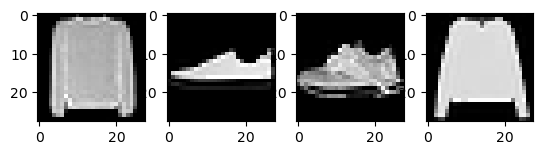

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(imges):
    plt.figure()
    for i in range(4):
        img = imges[i,0]
        img = img / 2 + 0.5 #unnormalize
        npimg = img.numpy()
        plt.subplot(1,4,i+1)
        plt.imshow(npimg, cmap='gray')
    plt.show

dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(images)

print('Classes are: ')
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## Create the deep neural network

### The network class

As before, we create a class object which inherits from the `torch.nn.Module`class to build our neural network. This includes the layer objects and the feedforward pass.

#### Define the network structure

We add to two convolutional layers before the neural network from tutorial 1.

To add a 2D-convolutional layer, we use the `nn.Conv2D()` object, which needs at least the following three parameters:
1. Number of input channels/ feature maps (corresponds to color channels, e.g. RGB)
2. Number of output channels / feature maps
3. Size of the convolutional kernel as single integer or tuple.
(for more information look in the [official PyTorch documentation](ttps://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)

As we want to process gray-scaled images, the input only has a single color channel. Therefore, the number of input channels into the first convolutional layer is $1$. We want $6$ feature maps and a kernel size of $5 \times 5$. In contrast to defining fully-connected layers, the pixel dimensions of the image is not relevant.

Creating our first convolutional layer leads to the following code line:

`self.conv1 = nn.Conv2d(1,6,5)`

With a similar call, we create the second convolutional layer. Here, since we defined 6 output feature maps for the previous layer, we need 6 input channels for this layer.

`self.conv1 = nn.Conv2d(6,16,5)`

As we want to perform a maximum pooling, we add a pooling layer with the first parameter as the size of the pooling kernel, and the second parameter as the stride of the pooling window:

`self.pool = nn.MaxPool2d(2,2)`

The last convolutional layer projects onto a fully connected layer where the explicit number of inputs is relevant again. The size of an image after a convolutional layer is:
`W-K+2P)/S+1` with input dimensions W, kernel size K, padding P and stride S. With max pooling here, it is halfed again. 

After the first convolution, the dimension is $(28-5+1)/2=12$ and after the second $(12-5+1)/2=4$. The last convolutional layer has 16 feature maps. Therefore, the number of outputs equals $16 \times 4 \times 4$ and represent the number of inputs of the fully-connected layer. 

`self.fc1 = nn.Linear(16*4*4,120)`

Then we add a second fully-connected layer:

`self.fc2 = nn.Linear(120,84)`

And the classification head with 10 output neurons:

`self.fc3 = nn.Linear(84,10)`

Please note, that here we only define, which layers we want to use in our network. The order of defining them is not important at the moment.

Afterwards, the feedforward pass is defined. A new concept here is the forward pass for the convolutional layer `x = self.pool(F.relu(self.conv1(x)))` where the input is passed through the convolutional layer. Then, the activation layer ReLU is used and, afterwards, max pooling is performed. Also, the output from the convolutional layer needs to be flattened for the fully-connected layer (as the images needed to be in the previous tutorial).

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        ## define the network structure with the layers
        self.conv1 = nn.Conv2d(1,6,5) # in_channels, out_channels, kernel_size 
        self.conv2 = nn.Conv2d(6,16,5) # in_channels,out_channels, kernel_size
        self.pool  = nn.MaxPool2d(2,2) # kernel_size, stride
        self.fc1   = nn.Linear(16*4*4, 120) # in_channels, out_channels
        self.fc2   = nn.Linear(120,84) # in_channels, out_channels
        self.fc3   = nn.Linear(84,10) # in_channels, out_channels

        
    def forward(self, x):
        ## define the functionality of each layer/between the layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x,1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#### Creating the network
Now we can simply create a new network object and assign it to the device identified above.

In [5]:
net = Net().to(device)

### Set up loss and optimizer
We use the `CrossEntropyLoss`as loss-function on the error between the network output and the correct labels and using the simple
Stochastic-Gradient-Desced (`SGD`) optimizer.
Please note, that the optimizer needs the parameters of our network `net.parameters()` as input to define which need to be tuned.

Further available loss functions and optimizers can be found on the [official PyTorch website](https://pytorch.org/docs/stable/nn.html)

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Training


In [21]:
from torch.utils.data import random_split
import sys
import os
notebook_dir = os.getcwd()
root_path = os.path.abspath(os.path.join(notebook_dir, ".."))
if root_path not in sys.path:
    sys.path.append(root_path)
    print(f"Added {root_path} to sys.path")

# Define your validation split
val_split = 0.2  # 20% for validation
val_size = int(len(trainset) * val_split)
train_size = len(trainset) - val_size

# Split into training and validation
train_dataset, val_dataset = random_split(trainset, [train_size, val_size])

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

from Utils.functions import train_model
from Utils.little_helpers import timer

with timer("Training process"):
    history = train_model(model=net,
                          train_loader=train_loader,
                          val_loader=val_loader,
                          criterion=nn.CrossEntropyLoss(label_smoothing=0.1),  # label smoothing to reduce overfit. Proper values are 0.01 to 0.2
                          optimizer=optimizer,
                          scheduler=scheduler,
                          patience=5,  # number of epochs to wait before early stopping 
                          monitor='val_loss',  # metric to monitor for early stopping. If this metric doesn't improve for the last `patience` epochs, early stopping is triggered
                          device=device,
                          num_epochs=2,
                          checkpoint_path="./",  # path to save the "best" model with best value of `monitor`
                          )

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [7]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the input data and labels
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimze
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        #print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'[{epoch +1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.068
[1,  4000] loss: 0.179
[1,  6000] loss: 0.141
[1,  8000] loss: 0.112
[1, 10000] loss: 0.102
[1, 12000] loss: 0.095
[1, 14000] loss: 0.084
[2,  2000] loss: 0.051
[2,  4000] loss: 0.074
[2,  6000] loss: 0.063
[2,  8000] loss: 0.053
[2, 10000] loss: 0.054
[2, 12000] loss: 0.057
[2, 14000] loss: 0.048
Finished Training


After training, we save the parameters of the trained network.

In [8]:
path = './mnist_net.pth'

In [9]:
torch.save(net.state_dict(), path)

## Test the network performance
We use the testloader object to see, how well the network will recognice the numbers in the test set.

In [10]:
dataiter = iter(testloader)
images, labels = next(dataiter)

We create a new network object and load the parameters from the trained network

In [11]:
net = Net()
net.load_state_dict(torch.load(path, weights_only=True))

<All keys matched successfully>

We test the first four images to see how well they work

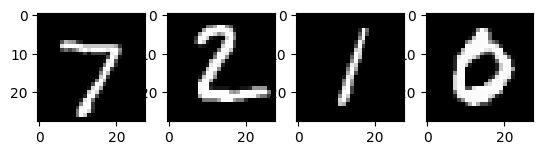

In [12]:
output = net(images)
imshow(images)

In [13]:
_, predicted = torch.max(output, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

Predicted:  7     2     1     0    


As this looks very promising, we write a loop to get the data from the testload batchwise and pass them through the network.

To avoid further training and to reduce the computational costs, we deactivate the calculation of gradients with `torch.no_grad()`

In [14]:
correct = 0
total   = 0

# use no_grad as we do not want further training
with torch.no_grad():
    for data in testloader:
        images, labels = data

        outputs = net(images)

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


print(f'Accuracy of the network on the test set: {100*correct // total}%')

Accuracy of the network on the test set: 98%


## Exercise 2: Implement a convolutional neural network for the FashionMNIST dataset

Similar to the previous tutorial and exercise, implement a CNN for the FashionMNIST dataset. Experiment with layer sizes, number of epochs, number of layers, batch size and kernel size.

In [ ]:
# immport torch and set device

In [ ]:
# load and plot data

In [ ]:
# define neural network layer and feedforward pass

In [ ]:
# create network and define loss function and optimizer

In [ ]:
# train the network and save the result

In [ ]:
# load the saved network

In [ ]:
# evaluate accuracy

## Conclusion

So in this tutorial we have covered:

1. How to define a convolutional layer and its forward pass